# Dog Classification Project 

This notebook goes through the processes of
1. Retrieving a dataset'
1. Uncompressing that dataset.
1. Uploading that dataset to an S3 bucket.
1. Setting up hyperparameter tuning using learning rate, weight decay, eps and batch size using the AdamW optimizer on ResNet18.
1. Starting a hyperparameter tuning job using 4 training jobs (2 at a time).
1. Record the best hyperparameters as discovered from the above.
1. Train a fine-tuned model using ResNet18 and the best hyperparameters over a larger number of epochs, recording profiling and debug data.
1. Re-run the training with profiling and debug turned off (due to issues deploying model trained with the above).
1. Deploy that model as an endpoint.
1. Test that endpoint with new images.


In [39]:
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached torchvision-0.11.1-cp37-cp37m-manylinux1_x86_64.whl (23.3 MB)
Killed


In [43]:
!pip install torchvision==0.5.0 --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 4.0 MB 16.3 MB/s            
     |████████████████████████████████| 753.4 MB 78.5 MB/s            ��████████████████▊      | 605.2 MB 7.8 MB/s eta 0:00:20 


In [40]:
import sagemaker
import boto3

## Dataset
The dataset I am using for this project is the dog breed images. This is a set of 6680 training images, and 836 test images of 133 dog breeds.

In [4]:
# Create a directory into which we are downloadning and extracting our data (to prevent clobbering local data)
!mkdir -p dogImages
# Wget with -c to make sure that we only retrieve the data if necessary.
!wget -c -P dogImages https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# Command to unzip data
#unzip commented out as this step has already been performed
#!unzip dogImages/dogImages.zip -d dogImages >/dev/null

--2021-11-22 18:57:52--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.48
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.48|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [5]:
# Retrieve the sagemaker session
sagemaker_session=sagemaker.Session()
# Retrieve the sagemaker S3 bucket
bucket = sagemaker_session.default_bucket()
# Set the prefix to us in the above bucket
prefix = "nd009t-c3-project/dogImages"
print("Uploading dogImages")
# Upload to s3 commented out as this step has already been performed
#inputs = sagemaker_session.upload_data(path="dogImages/dogImages", bucket=bucket, key_prefix=prefix)
inputs = 's3://sagemaker-us-east-1-574118147827/nd009t-c3-project/dogImages'
print("input spec (in this case, just an S3 path): {}".format(inputs))

role = sagemaker.get_execution_role()

Uploading dogImages
input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-574118147827/nd009t-c3-project/dogImages


## Hyperparameter Tuning

Setup the hyperparameter ranges. The ranges are chosen to be between 0.1x and 10x the default settings for these ranges.

In [6]:
#HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": sagemaker.tuner.ContinuousParameter(1e-4, 1e-1),
    "weight-decay": sagemaker.tuner.ContinuousParameter(1e-3, 1e-1),
    "eps": sagemaker.tuner.ContinuousParameter(1e-9, 1e-7),
    "batch-size": sagemaker.tuner.CategoricalParameter([32, 64]),
    #"test-batch-size": sagemaker.tuner.CategoricalParameter([64]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


In [10]:
#Estimator for HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge",
)

tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=20,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type="Auto",
)


In [ ]:
tuner.fit({"training": inputs}, wait=True)

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [13]:
# The best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-11-22 22:17:10 Starting - Preparing the instances for training
2021-11-22 22:17:10 Downloading - Downloading input data
2021-11-22 22:17:10 Training - Training image download completed. Training in progress.
2021-11-22 22:17:10 Uploading - Uploading generated training model
2021-11-22 22:17:10 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'eps': '7.346336091379899e-08',
 'lr': '0.0017517192986461164',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-11-22-19-14-26-921"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-574118147827/pytorch-training-2021-11-22-19-14-26-921/source/sourcedir.tar.gz"',
 'weight-decay': '0.03127956902459021'}

In [20]:
best_hyperparameters={'batch-size': int(best_estimator.hyperparameters()['batch-size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight-decay': best_estimator.hyperparameters()['weight-decay'],}
best_hyperparameters
#best_hyperparameters={'batch-size': 64,
# 'eps': 3.1900006493881446e-09,
# 'lr': 0.000778309355328367,
# 'weight-decay': 0.003764938898607458}
#best_hyperparameters

{'batch-size': 64,
 'eps': '7.346336091379899e-08',
 'lr': '0.0017517192986461164',
 'weight-decay': '0.03127956902459021'}

## Model Profiling and Debugging

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [61]:
from sagemaker.debugger import Rule, ProfilerRule, DebuggerHookConfig, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
hook_config = DebuggerHookConfig(
    #hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [62]:
estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    hyperparameters=best_hyperparameters,
    #profiler_config=profiler_config,
    #rules=rules,
)

In [63]:
estimator.fit({"training": inputs}, wait=True)

2021-11-23 03:36:37 Starting - Starting the training job...
2021-11-23 03:36:39 Starting - Launching requested ML instancesProfilerReport-1637638596: InProgress
...
2021-11-23 03:37:37 Starting - Preparing the instances for training.........
2021-11-23 03:39:07 Downloading - Downloading input data............
2021-11-23 03:40:57 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-11-23 03:40:54,968 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-11-23 03:40:54,970 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-11-23 03:40:54,978 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-11-23 03:40:56,444 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-11-23 03:41:19,762 sagemaker-training-toolkit INF

In [23]:
region = sagemaker_session.boto_region_name
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()


trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

Training jobname: pytorch-training-2021-11-22-23-58-17-705
Region: us-east-1


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-574118147827/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-574118147827/pytorch-training-2021-11-22-23-58-17-705/profiler-output


Profiler data from system is available
[2021-11-23 00:36:26.286 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagema

['CrossEntropyLoss_output_0',
 'CrossEntropyLoss_output_1',
 'CrossEntropyLoss_output_10',
 'CrossEntropyLoss_output_11',
 'CrossEntropyLoss_output_12',
 'CrossEntropyLoss_output_13',
 'CrossEntropyLoss_output_14',
 'CrossEntropyLoss_output_15',
 'CrossEntropyLoss_output_16',
 'CrossEntropyLoss_output_17',
 'CrossEntropyLoss_output_18',
 'CrossEntropyLoss_output_19',
 'CrossEntropyLoss_output_2',
 'CrossEntropyLoss_output_20',
 'CrossEntropyLoss_output_21',
 'CrossEntropyLoss_output_22',
 'CrossEntropyLoss_output_23',
 'CrossEntropyLoss_output_24',
 'CrossEntropyLoss_output_25',
 'CrossEntropyLoss_output_26',
 'CrossEntropyLoss_output_27',
 'CrossEntropyLoss_output_28',
 'CrossEntropyLoss_output_29',
 'CrossEntropyLoss_output_3',
 'CrossEntropyLoss_output_30',
 'CrossEntropyLoss_output_31',
 'CrossEntropyLoss_output_32',
 'CrossEntropyLoss_output_33',
 'CrossEntropyLoss_output_34',
 'CrossEntropyLoss_output_35',
 'CrossEntropyLoss_output_36',
 'CrossEntropyLoss_output_37',
 'CrossEntro

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


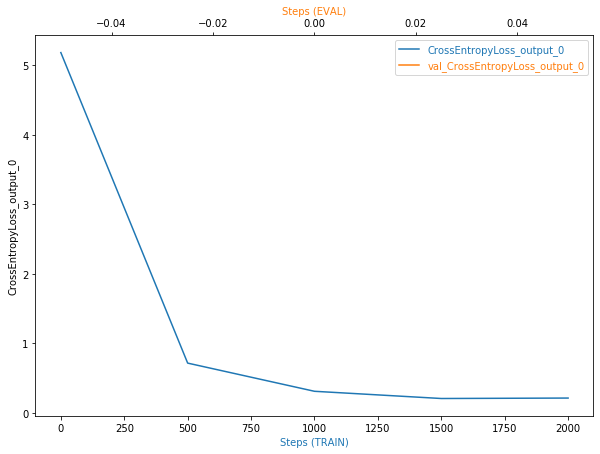

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
plot_tensor(trial, "CrossEntropyLoss_output_0")

While there is no anomalous behaviour in this output, were the loss erratic, increasing and decreasing with the number of steps, I would look into using different learning rates, probably smaller. Similarly, if the loss decreased very slowly, I would try an increased learning rate.

In [25]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

[2021-11-23 00:40:48.483 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO metrics_reader_base.py:134] Getting 35 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


You will find the profiler report in s3://sagemaker-us-east-1-574118147827/pytorch-training-2021-11-22-23-58-17-705/rule-output


## Model Deploying

In [64]:
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

-----------!

In [170]:
import base64 # encode/decode image in base64
import json
import requests
import torch
import torchvision
import PIL
import torchvision.transforms as transforms
import numpy as np

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Test images outside of dataset. The comment after is the result. All tested dogs are not breeds in the actual training data.
#PIL_image = PIL.Image.open('testImages/Penny.png') #24 Bichon frise
#PIL_image = PIL.Image.open('testImages/20200912_121320.jpg') #52, 24 Clumber Spaniel, Bichon Frise

#PIL_image = PIL.Image.open('testImages/Rolo.png') #120 Pharaoh Hound
#PIL_image = PIL.Image.open('testImages/DSC08918.JPG') #116 Parson Russell Terrier

#PIL_image = PIL.Image.open('testImages/DSC01822.JPG') #58 Dandie dinmont terrier
#PIL_image = PIL.Image.open('testImages/Lucy.png') #42 Cairn Terrier

#PIL_image = PIL.Image.open('testImages/IMG-20210419-WA0000.jpg') #97 Lakeland Terrier
#PIL_image = PIL.Image.open('testImages/IMG-20210727-WA0000.jpg') #72 German Shorthaired Pointer

#PIL_image = PIL.Image.open('dogImages/dogImages/test/024.Bichon_frise/Bichon_frise_01707.jpg') #24 
#PIL_image = PIL.Image.open('dogImages/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg') #1

image = transform(PIL_image)

payload = image.unsqueeze(dim=0)

response = predictor.predict(payload)

np.argmax(response) + 1

1

In [49]:
predictor.delete_endpoint()